## 4.3 Bayesian Change Point Detection

入手元:
https://github.com/gwgundersen/bocd/blob/master/bocd.py

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
from scipy.stats import norm

In [2]:
# 入手元コードで定義されている関数群

# Baysian Online Change Point Detection
def bocd(data, model, hazard):
    """Return run length posterior using Algorithm 1 in Adams & MacKay 2007.
    """
    # 1. Initialize lower triangular matrix representing the posterior as
    # function of time. Model parameters are initialized in the model class.
    T = len(data)
    R = np.zeros((T + 1, T + 1))
    R[0, 0] = 1
    message = np.array([1])

    for t in range(1, T + 1):
        # 2. Observe new datum.
        x = data[t - 1]

        # 3. Evaluate predictive probabilities.
        pis = model.pred_prob(t, x)

        # 4. Calculate growth probabilities.
        growth_probs = pis * message * (1 - hazard)

        # 5. Calculate changepoint probabilities.
        cp_prob = sum(pis * message * hazard)

        # 6. Calculate evidence
        new_joint = np.append(cp_prob, growth_probs)

        # 7. Determine run length distribution.
        R[t, :t + 1] = new_joint
        evidence = sum(new_joint)
        R[t, :] /= evidence

        # 8. Update sufficient statistics.
        model.update_statistics(t, x)

        # Setup message passing.
        message = new_joint

    return R

# Conjugate Bayesian analysis of the Gaussian distribution
class NormalKnownPrecision:

    def __init__(self, mean0, prec0):
        """Initialize model parameters.
        """
        self.mean0 = mean0
        self.prec0 = prec0
        self.mean_params = np.array([mean0])
        self.prec_params = np.array([prec0])

    def pred_prob(self, t, x):
        """Compute predictive probabilities.
        """
        d = lambda x, mu, tau: norm.pdf(x, mu, 1 / tau + 1)
        return np.array([d(x, self.mean_params[i], self.prec_params[i])
                         for i in range(t)])

    def update_statistics(self, t, x):
        """Update sufficient statistics.
        """
        # `offsets` is just a clever way to +1 all the sufficient statistics.
        offsets = np.arange(1, t + 1)
        new_mean_params = (self.mean_params * offsets + x) / (offsets + 1)
        new_prec_params = self.prec_params + 1
        self.mean_params = np.append([self.mean0], new_mean_params)
        self.prec_params = np.append([self.prec0], new_prec_params)

def plot_posterior(data, R):
    """Plot data, run length posterior, and groundtruth changepoints.
    """
    T = len(data)
    fig, axes = plt.subplots(2, 1, figsize=(20, 10))
    ax1, ax2 = axes

    ax1.scatter(range(0, T), data)
    ax1.plot(range(0, T), data)
    ax1.set_xlim([0, T])
    ax1.margins(0)

    norm = LogNorm(vmin=0.0001, vmax=1)
    ax2.imshow(np.rot90(R), aspect='auto', cmap='gray_r', norm=norm)
    ax2.set_xlim([0, T])
    # This just reverses the y-tick marks.
    ticks = list(range(0, T + 1, 50))
    ax2.set_yticks(ticks)
    ax2.set_yticklabels(ticks[::-1])
    ax2.margins(0)

    plt.tight_layout()
    plt.show()

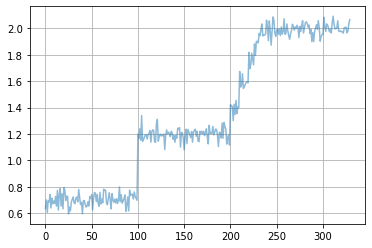

In [3]:
# 変化点のあるデータを作る
data = np.concatenate(
    [np.random.normal(0.7, 0.05, 100),
     np.random.normal(1.2, 0.05, 100),
     np.random.normal(1.4, 0.05, 10),
     np.random.normal(1.6, 0.05, 10),
     np.random.normal(1.8, 0.05, 10),
     np.random.normal(2.0, 0.05, 100)])
data

# データを表示
fig, ax = plt.subplots(nrows = 1, sharex = True)
ax.plot(data, alpha=0.5)
ax.grid()

In [4]:
mean0 = 0  # Prior on Gaussian mean.
prec0 = 0.2  # Prior on Gaussian precision.

model = NormalKnownPrecision(mean0, prec0)
R = bocd(data=data, model=model, hazard=1/50)
# The model becomes numerically unstable for large `T` because the mass is
# distributed across a support whose size is increasing.
for row in R:
    assert np.isclose(np.sum(row), 1)

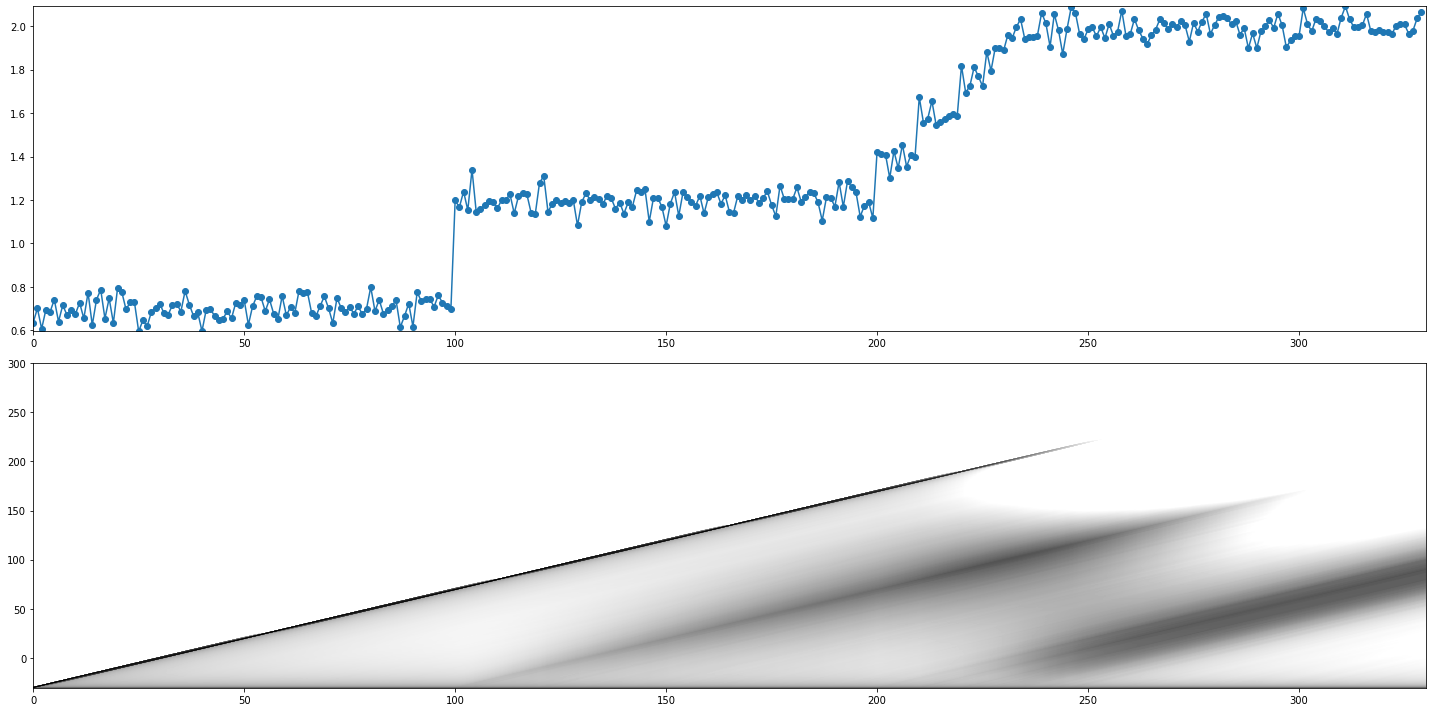

In [5]:
plot_posterior(data, R)